In [ ]:
!pip uninstall matplotlib
!pip install matplotlib

!pip intall seaborn


2023-12-07 16:50:31.443905: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 16:50:31.483654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 16:50:31.946097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100


2023-12-07 16:50:32.644492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-07 16:50:32.800063: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


31/31 [==============================] - 0s 5ms/step - loss: 1.3802 - accuracy: 0.2441 - val_loss: 1.3121 - val_accuracy: 0.4050
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 1.2469 - accuracy: 0.5222 - val_loss: 1.1962 - val_accuracy: 0.5620
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 1.1596 - accuracy: 0.5729 - val_loss: 1.1193 - val_accuracy: 0.5785
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 1.0984 - accuracy: 0.5739 - val_loss: 1.0644 - val_accuracy: 0.5950
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 1.0605 - accuracy: 0.5760 - val_loss: 1.0291 - val_accuracy: 0.5950
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 1.0376 - accuracy: 0.5739 - val_loss: 1.0063 - val_accuracy: 0.5992
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 1.0251 - accuracy: 0.5739 - val_loss: 0.9921 - val_accuracy: 0.5950
Epoch 8/100
31/31 [======

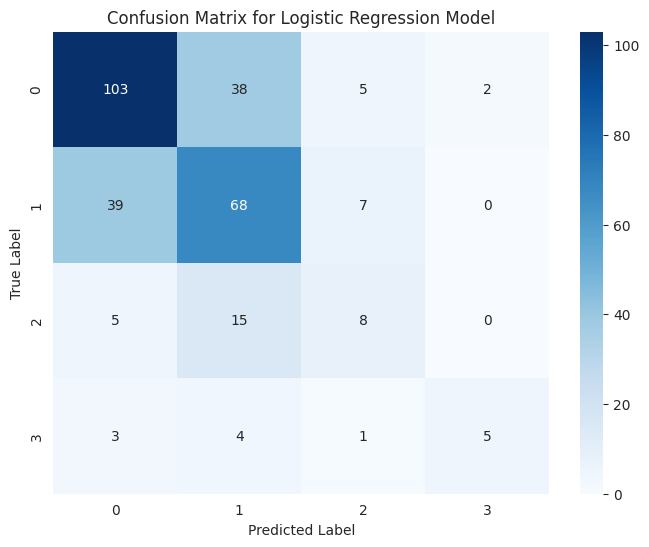

F1 Score: 0.6033725242973635

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       148
           1       0.54      0.60      0.57       114
           2       0.38      0.29      0.33        28
           3       0.71      0.38      0.50        13

    accuracy                           0.61       303
   macro avg       0.58      0.49      0.52       303
weighted avg       0.61      0.61      0.60       303


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np
import seaborn as sns
# Load the dataset
file_path = '../data/cleaned_all_phones.csv'
phone_data = pd.read_csv(file_path)

# Define custom price categories
bins = [0, 250, 500, 1000, phone_data['price(USD)'].max()]
labels = ['0-250', '251-500', '501-1000', '1000+']
phone_data['price_category'] = pd.cut(phone_data['price(USD)'], bins=bins, labels=labels, right=False)

# Selecting features and target variable
features = ['storage(GB)', 'video_4K', 'video_720p', 'ram(GB)', 'video_60fps', 'weight(g)', 'inches', 'video_240fps']
X = phone_data[features]
y = phone_data['price_category']

# Preprocessing for numerical data
numerical_cols = X.columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
    ])

# Convert categorical labels to one-hot encoding
y = pd.get_dummies(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Applying preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert sparse matrix to dense (if necessary)
X_train_transformed = X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed
X_test_transformed = X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed

# Manual train-validation split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_transformed, y_train, test_size=0.2, random_state=42)

# Building the ANN for Classification
model = Sequential([
    Dense(8, activation='tanh', input_shape=(X_train_final.shape[1],)),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer for the number of categories
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_final, y_train_final,
    epochs=100,
    validation_data=(X_val, y_val)
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_transformed, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plotting training and validation accuracy and loss
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'],  label='Training loss')
plt.plot(epochs, history.history['val_loss'],  label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predicting the Test set results
y_pred = model.predict(X_test_transformed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test.to_numpy(), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# F1 Score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"F1 Score: {f1}")

# Classification Report (includes F1 score for each class)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))
